# Kera, Example.

Load the fashion MNIST dataset and train it using Keras. For classification.

### Common Deep Learning Layers

| Layer Type            | Purpose / Function                                 | Typical Use Case                 | Key Parameters                  |
|-----------------------|----------------------------------------------------|----------------------------------|---------------------------------|
| **Dense (Fully Connected)** | Linear transformation + bias                   | MLPs, classifier heads            | units, activation               |
| **Convolutional (Conv1D/2D/3D)** | Extract spatial/temporal features via filters | Images, audio, video              | filters, kernel size, stride    |
| **Pooling (Max, Avg)** | Downsampling feature maps                         | CNNs (after conv layers)          | pool size, stride               |
| **Dropout**            | Randomly deactivate neurons during training        | Regularization                    | dropout rate (e.g., 0.5)        |
| **Batch Normalization**| Normalize across batch to speed up training        | CNNs, MLPs                        | momentum, epsilon               |
| **Activation**         | Add non-linearity                                  | Everywhere                        | type (ReLU, Sigmoid, etc.)      |
| **Flatten**            | Convert N-D input to 1D                            | Before dense layers               | –                               |
| **Reshape**            | Change tensor shape                                | Transition layers                 | target shape                    |
| **Embedding**          | Map categorical IDs to dense vectors               | NLP, recommender systems          | input_dim, output_dim           |
| **RNN / LSTM / GRU**   | Process sequential data with memory                | Time series, NLP                  | units, return_sequences         |
| **Attention / Self-Attention** | Compute weighted importance between inputs  | Transformers, LLMs                | heads, key/query/value dims     |
| **Layer Normalization**| Normalize across features per sample               | Transformers, NLP                 | epsilon                         |

In [9]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
print(f"TF version: {tf.__version__}, Keras: {keras.__version__}")

TF version: 2.19.0, Keras: 3.10.0


In [3]:
fashion = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion.load_data()

In [4]:
print(f"Shapes: {X_train_full.shape}, {y_train_full.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")
# the y_train is index into following
#   https://keras.io/api/datasets/fashion_mnist/
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
X_test = X_test / 255.0
X_validation, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_validation, y_train = y_train_full[:5000], y_train_full[5000:]

Shapes: (60000, 28, 28), (60000,)
Test: (10000, 28, 28), (10000,)


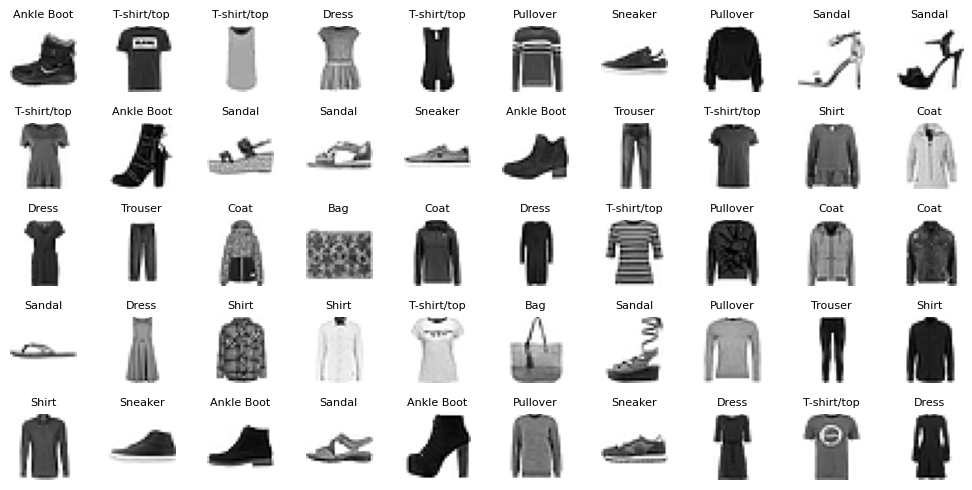

10 items-classes shown


In [5]:
# Show few images
fig, axes = plt.subplots(5,10, figsize=(10,5))
axes = axes.flatten()
items = set()
for idx, ax in enumerate(axes):
    ax.imshow(X_train_full[idx], cmap="binary")
    ax.set_title(f"{class_names[y_train_full[idx]]}", size=8)
    ax.axis('off')
    ax.set_facecolor('none')
    items.add(y_train_full[idx])
plt.tight_layout()
plt.show()
print(f"{len(items)} items-classes shown")

# Linear Models

1. __Input Layer: keras.layers.Input(shape=[28,28])__:
    - __Purpose:__ Specifies the shape of the input data.
    - __Shape:__ The input is a 2D tensor of shape [28, 28]
    - __Connection:__ This layer doesn’t compute anything; it just defines the input shape. The output (shape [28, 28]) is passed directly to the next layer.
2. __Flatten Layer: keras.layers.Flatten()__:
    - __Purpose:__ Converts the 2D input tensor into a 1D vector.
    - __Input Shape:__ [28, 28] (from the Input layer).
    - __Output Shape:__ The Flatten layer reshapes the input into a 1D vector of size 28 * 28 = 784. So, the output shape is [784].
    - __Connection:__ The 2D tensor is unrolled into a single vector of 784 elements, which is then fed into the next layer (Dense layer with 600 units).
3. __Dense Layer 1: keras.layers.Dense(600, activation="relu")__:
    - __Purpose:__ A fully connected layer with 600 neurons, using ReLU activation.
    - __Input Shape:__ [784] (from the Flatten layer).
    - __Output Shape:__ [600] (one output per neuron).
    - __Computation:__ Each of the 600 neurons is connected to all 784 inputs from the Flatten layer. A weighted sum is computed (W * X + b), where W is a weight matrix of shape [784, 600] and b is a bias vector of shape [600]. The ReLU activation (max(0, x)) is applied to the result.
    - __Connection:__ The output (a vector of size 600) is passed to the next Dense layer.
4. __Dense Layer 2: keras.layers.Dense(300, activation="relu")__:
    - __Purpose:__ A fully connected layer with 300 neurons, using ReLU activation.
    - __Input Shape:__ [600] (from the previous Dense layer).
    - __Output Shape:__ [300].
    - __Computation:__ Each of the 300 neurons is connected to all 600 inputs. The weight matrix is [600, 300], and the bias vector is [300]. ReLU activation is applied.
    - __Connection:__ The output (a vector of size 300) is fed into the next Dense layer.
5. __Dense Layer 3: keras.layers.Dense(100, activation="relu")__:
    - __Purpose:__ A fully connected layer with 100 neurons, using ReLU activation.
    - __Input Shape:__ [300] (from the previous Dense layer).
    - __Output Shape:__ [100].
    - __Computation:__ Each of the 100 neurons is connected to all 300 inputs. The weight matrix is [300, 100], and the bias vector is [100]. ReLU activation is applied.
    - __Connection:__ The output (a vector of size 100) is passed to the final Dense layer.
6. __Output Layer: keras.layers.Dense(10, activation="softmax")__:
    - __Purpose:__ A fully connected layer with 10 neurons, using Softmax activation for multi-class classification.
    - __Input Shape:__ [100] (from the previous Dense layer).
    - __Output Shape:__ [10].
    - __Computation:__ Each of the 10 neurons is connected to all 100 inputs. The weight matrix is [100, 10], and the bias vector is [10]. The Softmax activation normalizes the outputs into a probability distribution over the 10 classes (e.g., digits 0-9 for fashion MNIST).
    -  __Connection:__ This is the final layer, so its output (a vector of size 10) represents the model’s predictions.

In [6]:
# Create a model
# Create early stopping callback
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',      # watch validation loss
    patience=5,              # stop after 5 epochs of no improvement
    restore_best_weights=True  # restore model weights from best epoch
)
reg = keras.regularizers.l2(0.0005)

model1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28,28]),
        keras.layers.Flatten(),
        keras.layers.Dense(600, activation="relu", kernel_regularizer=reg),
        keras.layers.Dense(300, activation="relu", kernel_regularizer=reg),
        keras.layers.Dense(100, activation="relu", kernel_regularizer=reg),
        keras.layers.Dense(10, activation="softmax")
    ]
)
# sparse_categorical_crossentropy
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history = model1.fit(X_train, y_train, epochs=100,
                    callbacks=[early_stop],
                    validation_data=(X_validation, y_validation))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6875 - loss: 1.6070 - val_accuracy: 0.8442 - val_loss: 1.0798
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8307 - loss: 1.0869 - val_accuracy: 0.8388 - val_loss: 1.0459
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8490 - loss: 1.0139 - val_accuracy: 0.8566 - val_loss: 0.9816
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8591 - loss: 0.9624 - val_accuracy: 0.8756 - val_loss: 0.9230
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8648 - loss: 0.9320 - val_accuracy: 0.8730 - val_loss: 0.9043
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8693 - loss: 0.9012 - val_accuracy: 0.8770 - val_loss: 0.8705
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8781 - loss: 0.8652 - val_accuracy: 0.8760 - val_loss: 0.8568
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8826 - loss: 0

# Try  CNNs

| Layer (Type)       | Output Shape        | Parameters | Description                                     |
|--------------------|---------------------|------------|-------------------------------------------------|
| Input              | (28, 28, 1)         | 0          | Grayscale image input                          |
| Conv2D             | (28, 28, 32)        | 320        | 32 filters, 3×3 kernel, ReLU, padding='same'   |
| MaxPooling2D       | (14, 14, 32)        | 0          | 2×2 pooling                                    |
| Conv2D             | (14, 14, 64)        | 18,496     | 64 filters, 3×3 kernel, ReLU, padding='same'   |
| MaxPooling2D       | (7, 7, 64)          | 0          | 2×2 pooling                                    |
| Flatten            | (3136,)             | 0          | Flattens 3D volume to 1D vector                |
| Dense              | (128,)              | 401,536    | Fully connected layer with ReLU                |
| Dropout (0.5)      | (128,)              | 0          | Dropout for regularization                     |
| Dense (Output)     | (10,)               | 1,290      | Softmax for 10-class classification            |

In [7]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),  # Add channel dimension
    keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
X_train_cnn = X_train[..., np.newaxis]         # shape: (50000, 28, 28, 1)
X_validation_cnn = X_validation[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history2 = model2.fit(X_train_cnn, y_train, epochs=100,
                    callbacks=[early_stop],
                    validation_data=(X_validation_cnn, y_validation))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5373 - loss: 1.2779 - val_accuracy: 0.7850 - val_loss: 0.5979
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7675 - loss: 0.6343 - val_accuracy: 0.8148 - val_loss: 0.4760
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7994 - loss: 0.5469 - val_accuracy: 0.8564 - val_loss: 0.4221
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8223 - loss: 0.4918 - val_accuracy: 0.8576 - val_loss: 0.4020
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8336 - loss: 0.4604 - val_accuracy: 0.8622 - val_loss: 0.3780
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8403 - loss: 0.4394 - val_accuracy: 0.8736 - val_loss: 0.3569
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8480 - loss: 0.4208 - val_accuracy: 0.8808 - val_loss: 0.3388
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8592 -

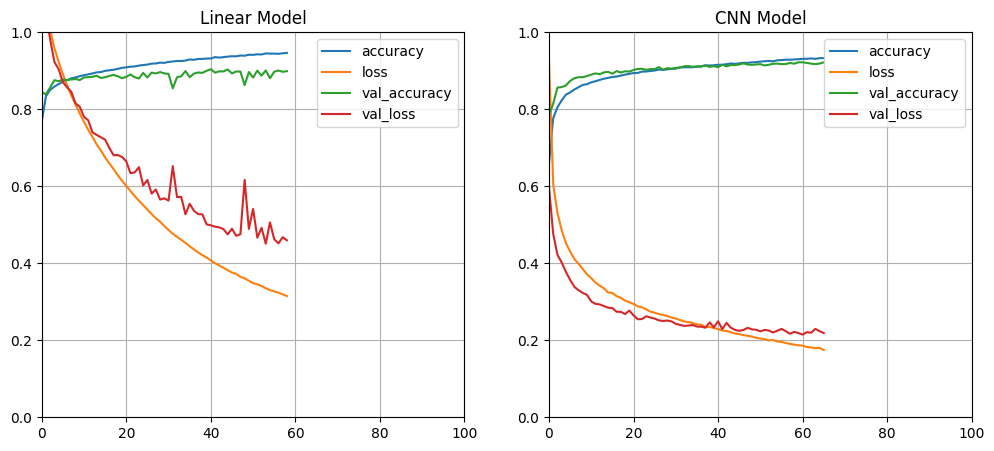

In [24]:
df = pd.DataFrame(history.history)
df2 = pd.DataFrame(history2.history)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
df.plot(ax=axes[0])
df2.plot(ax=axes[1])
for ax in axes:
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
axes[0].set_title("Linear Model")
axes[1].set_title("CNN Model")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9127 - loss: 0.2537
Accuracy: 0.9132999777793884, Loss: 0.248946875333786
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


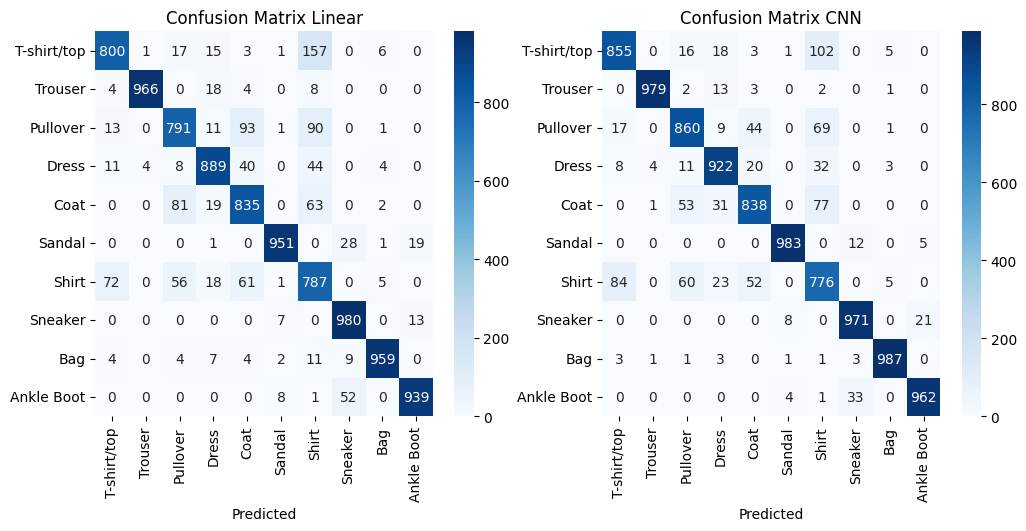

In [22]:
loss, accuracy = model2.evaluate(X_test_cnn, y_test)
print(f"Accuracy: {accuracy}, Loss: {loss}")
# Plot confusion matrix
fig, axes = plt.subplots(1,2, figsize=(12,5))
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix Linear")
axes[0].set_xlabel("Predicted")

y_pred = model2.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix CNN")
axes[1].set_xlabel("Predicted")
plt.show()

In [23]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Linear Model Accuracy: {accuracy}, Loss: {loss}")
loss, accuracy = model2.evaluate(X_test_cnn, y_test)
print(f"CNN Model Accuracy: {accuracy}, Loss: {loss}")
# calculate F1 score, precision, recall for both models
y_pred_linear = model1.predict(X_test)
y_pred_classes_linear = np.argmax(y_pred_linear, axis=1)
y_pred_cnn = model2.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
print(f"Linear Model F1 Score: {f1_score(y_test, y_pred_classes_linear, average='macro')}")
print(f"Linear Model Precision: {precision_score(y_test, y_pred_classes_linear, average='macro')}")
print(f"Linear Model Recall: {recall_score(y_test, y_pred_classes_linear, average='macro')}")
print(f"CNN Model F1 Score: {f1_score(y_test, y_pred_classes_cnn, average='macro')}")
print(f"CNN Model Precision: {precision_score(y_test, y_pred_classes_cnn, average='macro')}")
print(f"CNN Model Recall: {recall_score(y_test, y_pred_classes_cnn, average='macro')}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.4933
Linear Model Accuracy: 0.8896999955177307, Loss: 0.4889090359210968
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9127 - loss: 0.2537
CNN Model Accuracy: 0.9132999777793884, Loss: 0.248946875333786
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Linear Model F1 Score: 0.8909603204894918
Linear Model Precision: 0.8939858357432614
Linear Model Recall: 0.8897
CNN Model F1 Score: 0.9136437472655473
CNN Model Precision: 0.9142882009633692
CNN Model Recall: 0.9132999999999999
